In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import paired_distances
from helpers.iaml01cw2_helpers import *

In [2]:
Xtrn, Ytrn, Xtst, Ytst = load_FashionMNIST("fashionMNIST/")

In [3]:
Xtrn_orig = Xtrn.copy()
Xtst_orig = Xtst.copy()

In [4]:
Xtrn /= 255.0
Xtst /= 255.0

In [5]:
Xmean = np.mean(Xtrn, axis=0)
Xmean.shape

(784,)

In [6]:
Xtrn_nm = Xtrn - Xmean
Xtst_nm = Xtst - Xmean

In [7]:
# 1.1
Xtrn_nm[0, :4], Xtrn_nm[-1, :4]

(array([-3.13725490e-06, -2.26797386e-05, -1.17973856e-04, -4.07058824e-04]),
 array([-3.13725490e-06, -2.26797386e-05, -1.17973856e-04, -4.07058824e-04]))

The first four elements of the first and the last training are same. These are $[-3.13725490e-06, -2.26797386e-05, -1.17973856e-04, -4.07058824e-04]$

In [8]:
pca = PCA().fit(Xtrn_nm)
np.cumsum(pca.explained_variance_)

array([19.80980567, 31.92201614, 36.02817275, 39.41000114, 42.03477137,
       44.39561814, 45.99305849, 47.29288208, 48.21371016, 49.11026897,
       49.78758257, 50.4105813 , 50.93298506, 51.38301903, 51.79767897,
       52.20003983, 52.57655504, 52.93435518, 53.2468447 , 53.55758499,
       53.85343263, 54.13114393, 54.39361583, 54.6477607 , 54.89409828,
       55.13330681, 55.36063527, 55.5784942 , 55.78864658, 55.9887097 ,
       56.1767187 , 56.35753706, 56.53742863, 56.71195282, 56.87991243,
       57.04083814, 57.19793592, 57.35178141, 57.50082002, 57.64361547,
       57.78024291, 57.91377141, 58.04658342, 58.17127335, 58.29089545,
       58.40817903, 58.52332432, 58.63518368, 58.74495091, 58.85058303,
       58.95447496, 59.05683133, 59.15697134, 59.25473527, 59.34906419,
       59.44251987, 59.53198994, 59.61988546, 59.70669156, 59.79254405,
       59.87539577, 59.95739205, 60.03798623, 60.11729403, 60.19614165,
       60.27274665, 60.34851929, 60.42333271, 60.49504818, 60.56

In [14]:
pca.explained_variance_

array([1.98098057e+01, 1.21122105e+01, 4.10615661e+00, 3.38182839e+00,
       2.62477022e+00, 2.36084678e+00, 1.59744034e+00, 1.29982360e+00,
       9.20828072e-01, 8.96558812e-01, 6.77313601e-01, 6.22998726e-01,
       5.22403760e-01, 4.50033978e-01, 4.14659933e-01, 4.02360864e-01,
       3.76515209e-01, 3.57800138e-01, 3.12489521e-01, 3.10740295e-01,
       2.95847641e-01, 2.77711294e-01, 2.62471897e-01, 2.54144872e-01,
       2.46337582e-01, 2.39208531e-01, 2.27328458e-01, 2.17858935e-01,
       2.10152378e-01, 2.00063121e-01, 1.88009000e-01, 1.80818355e-01,
       1.79891572e-01, 1.74524192e-01, 1.67959608e-01, 1.60925709e-01,
       1.57097786e-01, 1.53845481e-01, 1.49038620e-01, 1.42795441e-01,
       1.36627447e-01, 1.33528502e-01, 1.32812006e-01, 1.24689931e-01,
       1.19622098e-01, 1.17283577e-01, 1.15145298e-01, 1.11859357e-01,
       1.09767231e-01, 1.05632115e-01, 1.03891933e-01, 1.02356366e-01,
       1.00140010e-01, 9.77639295e-02, 9.43289222e-02, 9.34556783e-02,
      

The explained variances of the first five components are $[1.98098057e+01, 1.21122105e+01, 4.10615661e+00, 3.38182839e+00, 2.62477022e+00]$

Text(0, 0.5, 'cumulative explained variance')

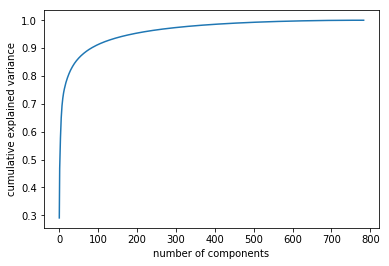

In [9]:
pca = PCA().fit(Xtrn_nm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

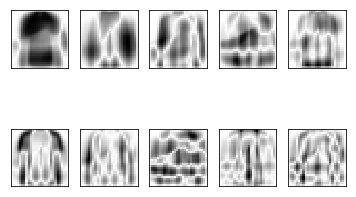

In [30]:
pca_comp_to_plot = abs(pca.components_[:10])
ROW = 2
COLUMN = 5
plt.figure() 
for i in range(ROW * COLUMN):
    image = pca_comp_to_plot[i].reshape((28,28))
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image, cmap='gray_r')  
    plt.xticks([])
    plt.yticks([])
plt.show()

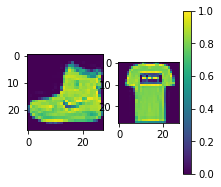

Image (#0): Which is label number '9', or label 'Ankle boot''


In [92]:
labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
sample = 0
each = Xtrn[sample].reshape((28, 28))
each_ = Xtrn[1].reshape((28, 28))
plt.figure(figsize=(3,3))
plt.subplot(1, 2, 1)
plt.imshow(each)
plt.subplot(1, 2, 2)
plt.imshow(each_)
plt.colorbar()
plt.show()
print("Image (#{}): Which is label number '{}', or label '{}''".format(sample, Ytrn[sample], labelNames[Ytrn[sample]]))

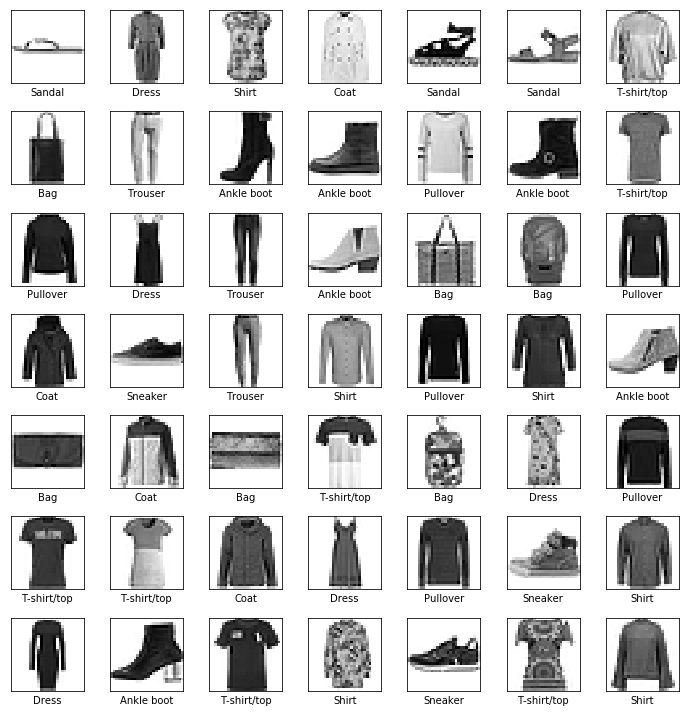

In [21]:
#Sample images
labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
ROW = 7
COLUMN = 7
plt.figure(figsize=(10, 10)) 
for i in range(ROW * COLUMN):
    temp = np.random.randint(0, len(Xtrn)+1)
    image = Xtrn[temp].reshape((28,28))
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image, cmap='gray_r')  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labelNames[Ytrn[temp]])
    plt.tight_layout()   
    
plt.show()

In [40]:
Xtrn.tolist()

KeyboardInterrupt: 

In [90]:
df.head()

,dist,y
0,9.544580,9
1,9.428048,0
2,5.898022,0
3,5.855456,3
4,8.427246,0


In [89]:
df[df.y == 0].nsmallest(2, ["dist"]).index[0]

13933

In [ ]:
Xtrn

In [ ]:
ROW = 10
COLUMN = 5
plt.figure(figsize=(10, 10))
for i in range(ROW * COLUMN):
    for j in range(10):
        
    image = Xtrn[temp].reshape((28,28))
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image, cmap='gray_r')  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labelNames[Ytrn[temp]])
    plt.tight_layout()   